# Comparação dos valores medidos e simulados de Ks

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import Infiltrometro, ALL_FUNCTIONS, nse

from xgboost import XGBRegressor
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [2]:
infil = pd.read_excel(r"D:\Mestrado\Trabalho Final\Dados\Levantamento em Campo\Compiled.xlsx", sheet_name="Infiltracao")
infil = Infiltrometro(infil)

[ True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False]


d:\Mestrado\Trabalho Final\Codigos\utils\infiltracao\infiltrometro.py:156: OptimizeWarning: Covariance of the parameters could not be estimated
  (c1, c2), covariance = curve_fit(self._equation_infiltration, t, I)


In [3]:
# K  = infil.K()  # Este valor de K é o K para -2cm de poropressão.
Ks = infil.Ks() # Ks é a condutividade Hidráulica Saturada.

Cálculos utilizando C1


In [4]:
alfa = Ks["alfa"].values
n = Ks["n"].values
K = Ks["K"].values
Ks = Ks["Ks"].values

sand = infil.infiltrations["Sand"].values
silt = infil.infiltrations["Silt"].values
clay = infil.infiltrations["Clay"].values

sand, silt, clay

(array([50., 68., 11., 32., 49., 53., 48., 68., 48., 75., 71., 53., 55.,
        89., 60., 46., 34., 42., 50., 61., 47., 39., 63., 58., 57., 33.,
        49., 44., 74., 55., 62., 63., 54., 40., 43., 41., 27., 31., 59.,
        57., 31., 29., 25., 49., 49., 28., 28., 14., 33., 38., 66., 31.,
        23., 56., 31., 33., 30., 23.,  7., 38., 53., 44., 47., 30.,  8.,
        15., 52., 28., 40., 44., 11., 53., 35., 27., 61., 15., 27., 44.,
        14., 41., 33., 50., 58., 63.]),
 array([ 9., 19., 45., 38., 10.,  4.,  6.,  4.,  6., 13., 17., 13., 32.,
         2., 15., 15., 39., 43., 25., 17., 10., 24., 22., 26., 21., 58.,
        25., 31.,  1., 20., 27., 18.,  7., 24., 18., 24., 35., 31., 18.,
        21., 26., 34., 40., 28., 23., 37., 26., 52., 46., 33., 17., 50.,
        34., 22., 25., 31., 42., 69., 20., 28., 28., 29., 28., 31., 36.,
        41., 27., 30., 24., 23., 30., 39., 33., 49., 25., 51., 40., 38.,
        23., 32., 45., 33., 26., 16.]),
 array([41., 13., 44., 30., 41., 43., 46., 2

In [5]:
KSS:dict[str, np.ndarray] = {}
for key, value in ALL_FUNCTIONS.items():
    KSS[key] = np.log10(value(sand, silt, clay))
KSS

A função proposta por Saxton não funciona corretamente


{'WMssc': array([-3.27260374, -3.15756374, -3.60893374, -3.44653374, -3.28134374,
        -3.24336374, -3.28253374, -3.13491374, -3.28253374, -3.09789374,
        -3.13285374, -3.25695374, -3.27118374, -2.98006374, -3.20936374,
        -3.31058374, -3.43358374, -3.38178374, -3.29676374, -3.20515374,
        -3.29580374, -3.37478374, -3.19824374, -3.24043374, -3.24011374,
        -3.46950374, -3.30399374, -3.34920374, -3.08700374, -3.25306374,
        -3.21302374, -3.19220374, -3.24066374, -3.36755374, -3.33680374,
        -3.36032374, -3.47815374, -3.44319374, -3.22112374, -3.24011374,
        -3.43564374, -3.46218374, -3.50016374, -3.30852374, -3.30097374,
        -3.47394374, -3.45733374, -3.59781374, -3.45138374, -3.39560374,
        -3.16900374, -3.47188374, -3.50556374, -3.24885374, -3.43413374,
        -3.42873374, -3.46703374, -3.55841374, -3.60010374, -3.38805374,
        -3.27960374, -3.34618374, -3.32298374, -3.45042374, -3.61703374,
        -3.57397374, -3.28532374, -3.46337

### Gerando funções com os próprios dados que possuo

In [6]:
# Seed para permitir reprodutibilidade dos valores pseudo-aleatórios
seed = 42

# Definir uma seed para reprodutibilidade
rng = np.random.default_rng(seed)

# Porcentagens de Treino e Teste
train_percent = 80
test_percent  = 20

# Indices de treino e teste
n_train = int(len(Ks)*train_percent/100)
n_teste = len(Ks) - n_train

idxs = np.arange(len(Ks))
idx_train = rng.choice(idxs, size=n_train, replace=False)
idx_test = np.setdiff1d(idxs, idx_train)

X = np.stack([sand, silt, clay], axis=1) # type: ignore
y = np.log10(Ks.astype(np.float64))

X_train = X[idx_train]
X_teste = X[idx_test]

y_train = y[idx_train]
y_teste = y[idx_test]

print("X Treino: ", X_train)
print("X Teste: ", X_teste)
print("y Treino: ", y_train)
print("y Teste: ", y_teste)

X Treino:  [[11. 30. 59.]
 [46. 15. 39.]
 [30. 31. 39.]
 [40. 24. 36.]
 [58. 26. 16.]
 [23. 69.  8.]
 [31. 31. 38.]
 [66. 17. 17.]
 [62. 27. 11.]
 [49. 23. 28.]
 [58. 26. 16.]
 [53. 39.  8.]
 [40. 24. 36.]
 [47. 10. 43.]
 [60. 15. 25.]
 [75. 13. 12.]
 [89.  2.  9.]
 [50. 33. 17.]
 [53. 28. 19.]
 [44. 31. 25.]
 [44. 29. 27.]
 [23. 34. 43.]
 [63. 16. 21.]
 [38. 33. 29.]
 [49. 28. 23.]
 [27. 49. 24.]
 [49. 10. 41.]
 [59. 18. 23.]
 [27. 35. 38.]
 [44. 23. 33.]
 [68. 19. 13.]
 [41. 24. 35.]
 [11. 45. 44.]
 [30. 42. 28.]
 [ 8. 36. 56.]
 [68.  4. 28.]
 [25. 40. 35.]
 [49. 25. 26.]
 [55. 20. 25.]
 [27. 40. 33.]
 [33. 58.  9.]
 [47. 28. 25.]
 [15. 41. 44.]
 [61. 25. 14.]
 [31. 25. 44.]
 [32. 38. 30.]
 [63. 18. 19.]
 [39. 24. 37.]
 [28. 26. 46.]
 [35. 33. 32.]
 [38. 28. 34.]
 [53.  4. 43.]
 [31. 26. 43.]
 [33. 45. 22.]
 [56. 22. 22.]
 [53. 13. 34.]
 [63. 22. 15.]
 [34. 39. 27.]
 [14. 23. 63.]
 [ 7. 20. 73.]
 [42. 43. 15.]
 [28. 37. 35.]
 [74.  1. 25.]
 [31. 50. 19.]
 [14. 52. 34.]
 [61. 17. 22.]

### Random Forest
---

In [7]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
train_rf = rf.predict(X_train)
pred_rf = rf.predict(X_teste)
serie_rf = rf.predict(X)

KSS["Rf"] = serie_rf

In [8]:
# XGBoost
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
train_xgb = xgb.predict(X_train)
pred_xgb = xgb.predict(X_teste)
serie_xgb = xgb.predict(X)

KSS["XGB"] = serie_xgb

In [9]:
# Linear
lin = LinearRegression()
lin.fit(X_train, y_train)
train_lin = lin.predict(X_train)
pred_lin = lin.predict(X_teste)
serie_lin = lin.predict(X)

a, b, c = lin.coef_
d = lin.intercept_

print(f"Ajustado: log10(K) = {a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f}")

KSS["Lin"] = serie_lin

Ajustado: log10(K) = 0.0145*Sand + 0.0074*Silt + -0.0220*Clay + -1.6531


In [10]:
# Exponencial
def exponencial(X, a, b, c, d):
    sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]
    return np.exp(a * sand + b * silt + c * clay + d)

popt, pcov = curve_fit(exponencial, X_train, np.pow(10, y_train))

a, b, c, d = popt
print(f"Ajustado: Ks = exp({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f})")

serie_exp = exponencial(X, *popt)
KSS["Exp"] = np.log10(serie_exp)

Ajustado: Ks = exp(-16.4630*Sand + -16.4884*Silt + -16.7196*Clay + 1649.0859)


In [11]:
# Potencial
def potencial(X, a, b, c, d, e):
    sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]

    t1 = a * sand + b * silt + c * clay + d
    return np.pow(e, t1)

popt, pcov = curve_fit(potencial, X_train, np.pow(10, y_train))

a, b, c, d, e = popt
print(f"Ajustado: Ks = {e}^({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f})")

serie_pot = potencial(X, *popt)
KSS["Pot"] = np.log10(serie_pot)

Ajustado: Ks = 0.9930542001144312^(-4.0604*Sand + -0.4129*Silt + 32.7527*Clay + 6.5340)


In [12]:
# Multi
def multi(X, a, b, c, d):
    sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]
    
    t1=a * sand + b * silt + c * clay

    return  d*t1

popt, pcov = curve_fit(multi, X_train, np.pow(10, y_train))

a, b, c, d = popt
print(f"Ajustado: Ks = {d:.4f}*({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay)")

serie_multi = multi(X, *popt)
KSS["Multi"] = np.log10(serie_multi)

Ajustado: Ks = -0.0031*(-1.4633*Sand + -0.8471*Silt + 1.5352*Clay)


C:\Users\felip\AppData\Local\Temp\ipykernel_27636\601614739.py:15: RuntimeWarning: invalid value encountered in log10
  KSS["Multi"] = np.log10(serie_multi)


In [13]:
# Eq1
def eq1(X, a, b, c, d, e, f):
    sand, silt, clay = X[:, 0], X[:, 1], X[:, 2]
    
    t1=a * sand + b * silt + c * clay + d

    return  e*np.pow(t1, f)

popt, pcov = curve_fit(eq1, X_train, np.pow(10, y_train))

a, b, c, d, e, f = popt
print(f"Ajustado: Ks = {e:.4f}*({a:.4f}*Sand + {b:.4f}*Silt + {c:.4f}*Clay + {d:.4f})^{f:.4f}")

serie_eq1 = eq1(X, *popt)
KSS["EQ1"] = np.log10(serie_eq1)

Ajustado: Ks = 0.8128*(0.4340*Sand + 0.2282*Silt + 0.2587*Clay + -26.1774)^0.9645


C:\Users\felip\AppData\Local\Temp\ipykernel_27636\1417084092.py:7: RuntimeWarning: invalid value encountered in power
  return  e*np.pow(t1, f)


### Avaliação dos modelos
---

In [14]:
# Avaliação
print("Valores de Teste")
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"RMSE - {key}:", root_mean_squared_error(y_teste, value[idx_test]))
print()
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"NSE - {key}:", nse(value[idx_test], y_teste, y.mean()))

print("----------------------------------------------------")

print("Valores de treino")
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"RMSE - {key}:", root_mean_squared_error(y_train, value[idx_train]))
print()
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"NSE - {key}:", nse(value[idx_train], y_train, y.mean()))

print("----------------------------------------------------")

print("Toda a Série")
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"RMSE - {key}:", root_mean_squared_error(y, value[idxs]))
print()
for key, value in KSS.items():
    value[np.isnan(value)] = 0
    print(f"NSE - {key}:", nse(value[idxs], y, y.mean()))

Valores de Teste
RMSE - WMssc: 1.7472639342575542
RMSE - COSBY: 1.766440495971562
RMSE - ROssc: 2.22630198807792
RMSE - JULIA: 2.026765045624455
RMSE - Puckett: 3.276743377029439
RMSE - DanePuckett: 2.2911977857555876
RMSE - Saxton: 8.587814794910225
RMSE - Rf: 0.3997900897342783
RMSE - XGB: 0.5751314436391324
RMSE - Lin: 0.48852582132327665
RMSE - Exp: 1.0968445123761097
RMSE - Pot: 1.0965423266763656
RMSE - Multi: 0.747204985023538
RMSE - EQ1: 2.4061810451602814

NSE - WMssc: -6.519388112690733
NSE - COSBY: -6.685347355583426
NSE - ROssc: -11.20769371507711
NSE - JULIA: -9.117478439984355
NSE - Puckett: -25.44541196744588
NSE - DanePuckett: -11.929765193331834
NSE - Saxton: -180.64808175126527
NSE - Rf: 0.6063325338224994
NSE - XGB: 0.18529627815269256
NSE - Lin: 0.4121851907654248
NSE - Exp: -1.9631634615210407
NSE - Pot: -1.961530956153073
NSE - Multi: -0.3751339287089548
NSE - EQ1: -13.260083838043487
----------------------------------------------------
Valores de treino
RMSE - WM

### Plot das Previsões

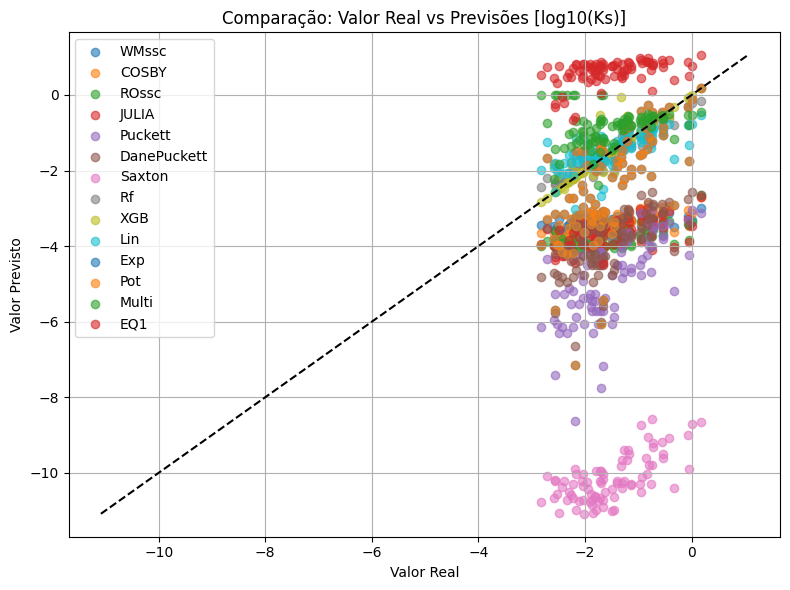

In [15]:
plt.figure(figsize=(8, 6))

min_val = y.min()
max_val = y.max()

# Real vs Simulado
for key, value in KSS.items():
    plt.scatter(y, value, alpha=0.6, label=key)

    min_val = min(min_val, value.min())
    max_val = max(max_val, value.max())

plt.plot([min_val, max_val], [min_val, max_val], 'k--')

# Estética
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")
plt.title("Comparação: Valor Real vs Previsões [log10(Ks)]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()